<a href="https://colab.research.google.com/github/sepidehrezvani/10-/blob/main/Product_codes_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

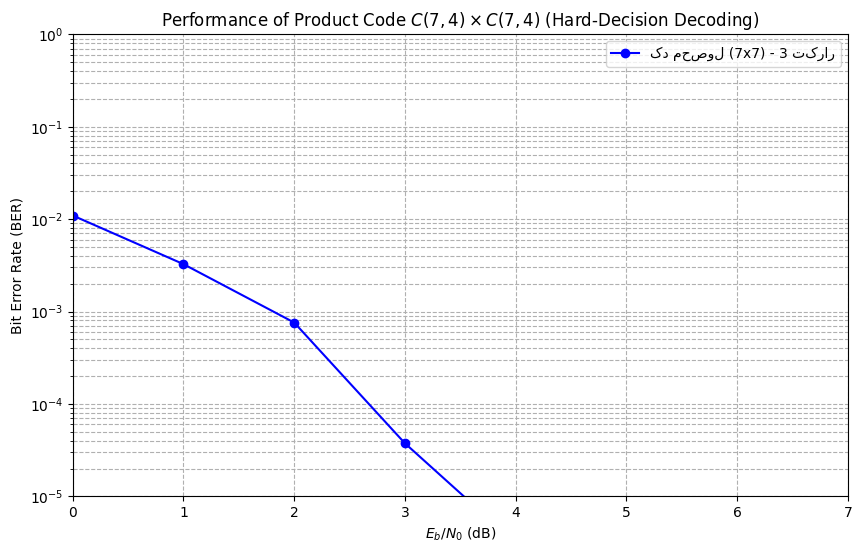

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- ۱. تنظیمات پارامترهای کدگذاری هم‌بندی (Hamming Code) (7, 4) ---
# Product Code: C(7, 4) x C(7, 4)
k_info = 4      # تعداد بیت اطلاعات در کد داخلی
n_codeword = 7  # طول کلمه کد
k_block = k_info * k_info # 16 بیت اطلاعات در هر بلوک محصول

# ماتریس مولد G برای کد هم‌بندی (7, 4) (سیستماتیک)
# G = [ I_4 | P ]
G = np.array([
    [1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1]
])

# ماتریس بررسی توازن H برای کد هم‌بندی (7, 4)
# H = [ P.T | I_3 ]
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
])

# --- ۲. تنظیمات شبیه سازی ---
N_symbols = 2 * 10**4 # تعداد بلوک‌های داده (هر بلوک 4x4)
Eb_N0_dB_range = np.arange(0, 8, 1) # محدوده Eb/N0 بر حسب دسی‌بل
MAX_ITER = 3 # حداکثر تکرار برای دکودینگ تکرارشونده

# --- ۳. توابع کدگذاری و مدولاسیون ---

def hamming_encode(data, G):
    """کدگذاری با کد هم‌بندی (7, 4)"""
    # data: (N_rows, k_info)
    return (data @ G) % 2

def product_code_encode(data_blocks, G):
    """کدگذاری دو مرحله‌ای (سطرها و ستون‌ها)"""
    # data_blocks: (N_blocks, k_info, k_info)
    N_blocks = data_blocks.shape[0]

    # 1. کدگذاری سطری (C1)
    coded_rows = np.zeros((N_blocks, k_info, n_codeword), dtype=int)
    for i in range(N_blocks):
        coded_rows[i] = hamming_encode(data_blocks[i], G)

    # 2. کدگذاری ستونی (C2)
    coded_block = np.zeros((N_blocks, n_codeword, n_codeword), dtype=int)
    for i in range(N_blocks):
        for j in range(n_codeword): # برای هر ستون
            # استخراج داده ستونی از خروجی مرحله 1 (4 بیت اطلاعات ستونی)
            column_data = coded_rows[i][:, j].reshape(k_info)
            # کدگذاری ستونی و تبدیل به بردار
            coded_column = hamming_encode(column_data[np.newaxis, :], G).flatten()
            coded_block[i, :, j] = coded_column

    # خروجی: (N_blocks, 7, 7)
    return coded_block

def BPSK_modulation(coded_blocks):
    """تبدیل بیت‌ها به سمبل‌های BPSK (+1, -1)"""
    return 1 - 2 * coded_blocks

def AWGN_channel(tx_symbols, Eb_N0_dB):
    """مدل کانال AWGN"""
    Eb_N0_linear = 10**(Eb_N0_dB / 10)

    # برای مدولاسیون BPSK، Eb/N0 = 1 / (2 * sigma^2)
    sigma = np.sqrt(1 / (2 * Eb_N0_linear))

    noise = sigma * np.random.normal(0, 1, tx_symbols.shape)
    return tx_symbols + noise

def hard_decision(rx_symbols):
    """تصمیم سخت (تبدیل دوباره به بیت 0 و 1)"""
    return (rx_symbols < 0).astype(int)

# --- ۴. توابع دکودینگ (با رفع خطای ValueError) ---

def hamming_decode_hard(received_bits, H):
    """
    دکودینگ ساده با تصمیم سخت برای کد هم‌بندی (7, 4)
     received_bits: (7,)
     H: (3, 7)
    """

    # 1. محاسبه سندرم: سندرم بردار (3,) است
    # syndrome = received_bits * H.T (مدول 2)
    syndrome = (received_bits @ H.T) % 2

    # 2. تبدیل سندرم به اندیس خطا
    # مقایسه هر سطر از H.T (که 7 سطر 3 عنصری دارد) با بردار syndrome (3 عنصری)
    # H.T دارای ابعاد (7, 3) است.
    # اینجاست که خطا رفع شد: مقایسه H.T (7x3) با syndrome (3,) بر اساس سطرها.
    error_indices = np.where(np.all(H.T == syndrome, axis=1))[0]

    decoded_bits = received_bits.copy()

    # 3. تصحیح خطا (در صورت وجود یک خطای قابل تصحیح)
    if len(error_indices) == 1:
        err_idx = error_indices[0]
        # flip the bit at the error location (0 to 6)
        decoded_bits[err_idx] = 1 - decoded_bits[err_idx]

    # استخراج بیت‌های اطلاعات (4 بیت اول، به فرض سیستماتیک بودن کد)
    info_bits = decoded_bits[:k_info]
    return info_bits, decoded_bits

def iterative_decoder(received_block_hard, H, max_iter):
    """دکودینگ تکرارشونده برای کد محصول (با تصمیم سخت)"""

    current_block = received_block_hard.copy()

    for _ in range(max_iter):

        # 1. دکودینگ سطری (C1)
        next_block = current_block.copy()
        for i in range(n_codeword):
            # دکود کردن سطر i-ام و جایگزینی با نتیجه تصحیح شده
            _, corrected_row = hamming_decode_hard(current_block[i, :], H)
            next_block[i, :] = corrected_row

        current_block = next_block.copy()

        # 2. دکودینگ ستونی (C2)
        next_block = current_block.copy()
        for j in range(n_codeword):
            # دکود کردن ستون j-ام
            _, corrected_column = hamming_decode_hard(current_block[:, j], H)
            next_block[:, j] = corrected_column

        current_block = next_block.copy()

    # استخراج بیت‌های اطلاعات (4x4 بالا سمت چپ)
    decoded_info = current_block[:k_info, :k_info]
    return decoded_info

# --- ۵. شبیه‌سازی اصلی (Monte Carlo) ---
sim_ber = []
for Eb_N0_dB in Eb_N0_dB_range:

    # 1. تولید بیت‌های اطلاعات و تقسیم به بلوک‌ها
    info_bits = np.random.randint(0, 2, N_symbols * k_block)
    data_blocks = info_bits.reshape(N_symbols, k_info, k_info)

    # 2. کدگذاری (Product Code)
    coded_blocks = product_code_encode(data_blocks, G)

    # 3. مدولاسیون BPSK و افزودن نویز
    tx_symbols = BPSK_modulation(coded_blocks).flatten()
    rx_symbols = AWGN_channel(tx_symbols, Eb_N0_dB)

    # 4. دمدولاسیون و تبدیل به بلوک‌های دریافتی (تصمیم سخت)
    received_bits_hard = hard_decision(rx_symbols).reshape(N_symbols, n_codeword, n_codeword)

    # 5. دکودینگ تکرارشونده برای تمام بلوک‌ها
    decoded_info_list = []
    for i in range(N_symbols):
        decoded_info = iterative_decoder(received_bits_hard[i], H, MAX_ITER)
        decoded_info_list.append(decoded_info)

    decoded_info_all = np.array(decoded_info_list).flatten()

    # 6. محاسبه BER
    n_errors = np.sum(info_bits != decoded_info_all)
    ber = n_errors / len(info_bits)
    sim_ber.append(ber)

# --- ۶. رسم نمودار ---
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_dB_range, sim_ber, 'bo-', label=f'کد محصول ({n_codeword}x{n_codeword}) - {MAX_ITER} تکرار')
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title(f'Performance of Product Code $C({n_codeword},{k_info}) \\times C({n_codeword},{k_info})$ (Hard-Decision Decoding)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.xlim([Eb_N0_dB_range[0], Eb_N0_dB_range[-1]])
plt.ylim([1e-5, 1])
plt.show()